### *Patient Stratification* ###

In [46]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import SpectralBiclustering
from collections import defaultdict
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from clusteval import clusteval
import os
from sklearn.decomposition import PCA
#import pacmap
from sklearn.manifold import TSNE



In [48]:
dir = 'Lisbon+Coimbra'
parent_dir = '../data/'+dir
# Path 
path = os.path.join(parent_dir, 'results') 
os.mkdir(path) 

Find discriminative patterns using biclustering

In [65]:
class Biclustering(BaseEstimator,TransformerMixin):
    def __init__(self, n_clusters = 50, method = 'bistochastic',svd_method = 'randomized', random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.svd_method = svd_method
        self.random_state = random_state
        self.biclusters = []

    def fit(self, X):
        # Clear biclusters to prevent accumulation
        self.biclusters = []
        self.x_train = X
        self.biclustering = SpectralBiclustering(
            n_clusters=self.n_clusters, 
            method=self.method, 
            svd_method=self.svd_method, 
            random_state=self.random_state)
  
        self.biclustering.fit(X)
        self.post_processing_bicluster(X)
        self.filter_trivial()

        # Check if biclusters were created
        if len(self.biclusters) == 0:
            print("Warning: No biclusters were found.")
        else:
            print(f"Found {len(self.biclusters)} biclusters.")
        return self

    def get_number_bics(self):
        return len(self.biclusters)

    def filter_trivial(self):
        return [bic for bic in self.biclusters if len(bic[0]) >= 2 and len(bic[1]) >= 2]
        #print(self.biclusters)

    def post_processing_bicluster(self,X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        # Extracting the biclusters
        n_biclusters = max(list(self.biclustering.row_labels_) + list(self.biclustering.column_labels_)) + 1
        rows = defaultdict(list)
        cols = defaultdict(list)

        row_labels = self.biclustering.row_labels_
        col_labels = self.biclustering.column_labels_

        for i, label in enumerate(row_labels):
           rows[label].append(X.index[i])

        for j, label in enumerate(col_labels):
            cols[label].append(X.columns[j])
        
        # Build biclusters
        self.biclusters = [[rows[i], cols[i]] for i in range(n_biclusters)]
        
        
    def transform(self, X):
        
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        # Initialize dictionary for distances

        distance_matrix = []
        if len(self.biclusters) == 0:
            print('Warning: No biclusters found, returning zero matrix')
            return np.zeros(((X.shape[0], 1)))
        #col_name = []
        for b in range(len(self.biclusters)):
            P = self.x_train.loc[self.biclusters[b][0],self.biclusters[b][1]] #patterns in the train set
            # Check if P is empty or has NaNs
            if P.empty or P.isnull().values.any():
                continue
            y_labels = P.columns
            P = P.mean(axis = 0)
            if len(P) == 0:
                continue
            # Precompute row submatrix 
            X_submatrix = X.loc[:, y_labels]
            # Make sure shapes match before subtraction
            if X_submatrix.shape[1] != len(P):
                continue  # Skip if shapes are incompatible
            # Compute the distance for each row
            diff = (X_submatrix - P) ** 2
            distance_matrix.append(np.sqrt(diff.sum(axis=1)) / len(P))
            #col_name.append('bic_' + str(b)) 

        if len(distance_matrix) == 0:
            print("Warning: No valid distances computed, returning zero matrix")
            return np.zeros(((X.shape[0], 1)))
        distance_matrix = np.array(distance_matrix).T
        
        if len(distance_matrix[1]) == 1: #if one feature
            distance_matrix = distance_matrix.reshape(-1, 1)
        #distance_matrix = pd.DataFrame(distance_matrix, index = col_name).T
        
        return distance_matrix
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def get_biclusters(self):
        # Initialize an empty list to store each bicluster's data as a row
        bicluster_rows = []
        
        for b in range(len(self.biclusters)):
            # Dictionary to hold data for the current bicluster
            bicluster_data = {'ID': b, 'Pattern': [], 'n_samples': []}

            # Loop through the features (columns) for this bicluster
            for feature in self.biclusters[b][1]:
                # Get the data for the rows and current feature in the bicluster
                feature_values = self.x_train.loc[self.biclusters[b][0], feature]
                
                # Calculate the min and max values
                min_val = feature_values.min()
                max_val = feature_values.max()
                
                # Append the pattern in the format 'feature = [min, max]'
                bicluster_data['Pattern'].append(f'{feature} = [{min_val:.2f}, {max_val:.2f}]')
            bicluster_data['n_samples'].append(len(feature_values))
            # Append the bicluster data to the list of rows
            bicluster_rows.append(bicluster_data)
        
        # Convert the list of bicluster data into a DataFrame
        bicluster_table = pd.DataFrame(bicluster_rows)
        
        # Display the table
        print(bicluster_table)
        return bicluster_table

Clustering: finding patient subtypes

In [59]:
def hierarchical_clustering(data, n_clust):
    """
    Computes the agglomerative clustering 

    Parameters
    ----------
    data: data to cluster
    """
    plt.ylabel('distance')
    clusters = shc.linkage(data, method="ward", metric="euclidean")
    #print(clusters)
    with open('../data/'+dir+'/results/{}dendrogram_distances.csv'.format(n_clust), "w") as f:
        wr = csv.writer(f)
        wr.writerows(clusters)

    shc.dendrogram(clusters, p = 20, truncate_mode = 'lastp', # show only the last p merged clusters
                show_leaf_counts = False) 
    plt.gcf()
    plt.savefig('../data/'+dir+'/results/dendrogram.pdf')

    Ward_model = AgglomerativeClustering(n_clusters= n_clust, metric='euclidean', linkage='ward')
    Ward_model.fit(data)
    #print(Ward_model.distances_)
    cluster_labels = Ward_model.fit_predict(data)

    
    shc.dendrogram(clusters,p= 20, truncate_mode ='lastp',show_leaf_counts=False, leaf_font_size=4)
    leaves = shc.dendrogram(clusters, no_plot = True)['leaves']

    if max(leaves) >= len(data):
        # Remove out-of-bounds leaves
        leaves = [i for i in leaves if i < len(data)]
  
    ordered_labels = cluster_labels[leaves]
    for i in range(1, len(ordered_labels)):
        if ordered_labels[i] != ordered_labels[i-1]:
            print(ordered_labels[i] )
         
    print(ordered_labels)

    print('Silhouette Score: ', silhouette_score(data, Ward_model.labels_, metric='euclidean'))
    print('Calinski Harabasz Score: ', calinski_harabasz_score(data, Ward_model.labels_))
    print('Davies Bouldin Score: ', davies_bouldin_score(data, Ward_model.labels_))

    return Ward_model.labels_

Found 50 biclusters.
2
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Silhouette Score:  0.3347592611469245
Calinski Harabasz Score:  45.02617627232044
Davies Bouldin Score:  1.062140382923482


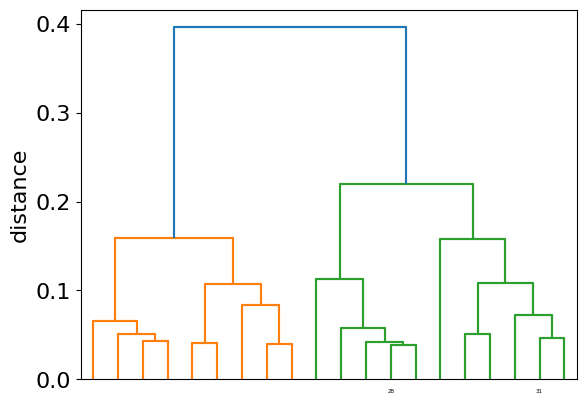

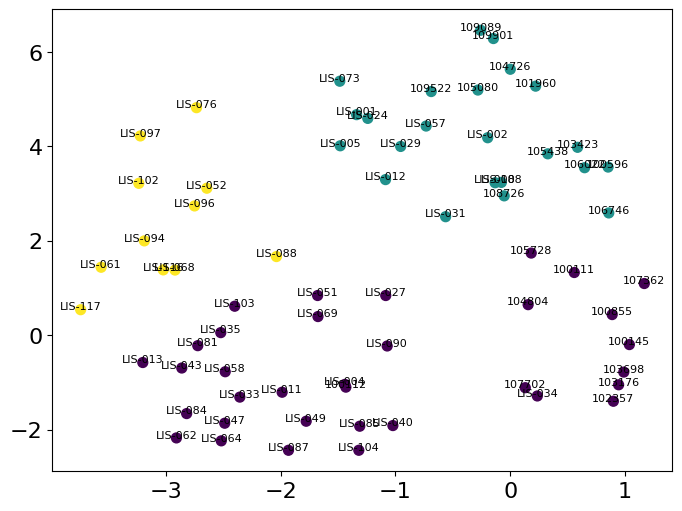

In [68]:
df = pd.read_csv('../data/'+dir+'/data.csv')
df = df.loc[df['Group'] == 'MCI-AD']
patient_code = list(df['Code'])

drop_features = ['Code', 'CSF date', 'ug/uL','Volume for 40ug', 'Idade', 'Sexo','CSF data tTau', 'CSF data pTau', 'CSF data abeta42', 'Group']
df.drop(columns = drop_features, inplace = True)

#biclustering
biclustering = Biclustering()
X = biclustering.fit_transform(df)

labels = hierarchical_clustering(X, 3)

pca = TSNE(n_components=2)
X_pca = pca.fit_transform(X)

# Step 4: Plot the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)

# Step 5: Annotate points with labels (here, we're using the original cluster labels)
for i in range(X_pca.shape[0]):
    plt.annotate(patient_code[i], (X_pca[i, 0], X_pca[i, 1]), fontsize= 8, ha='center')


[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.


Found 50 biclusters.


[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 557.59it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


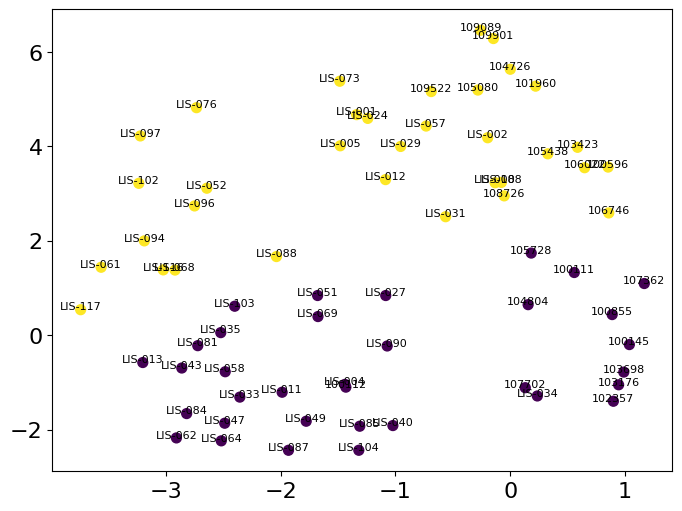

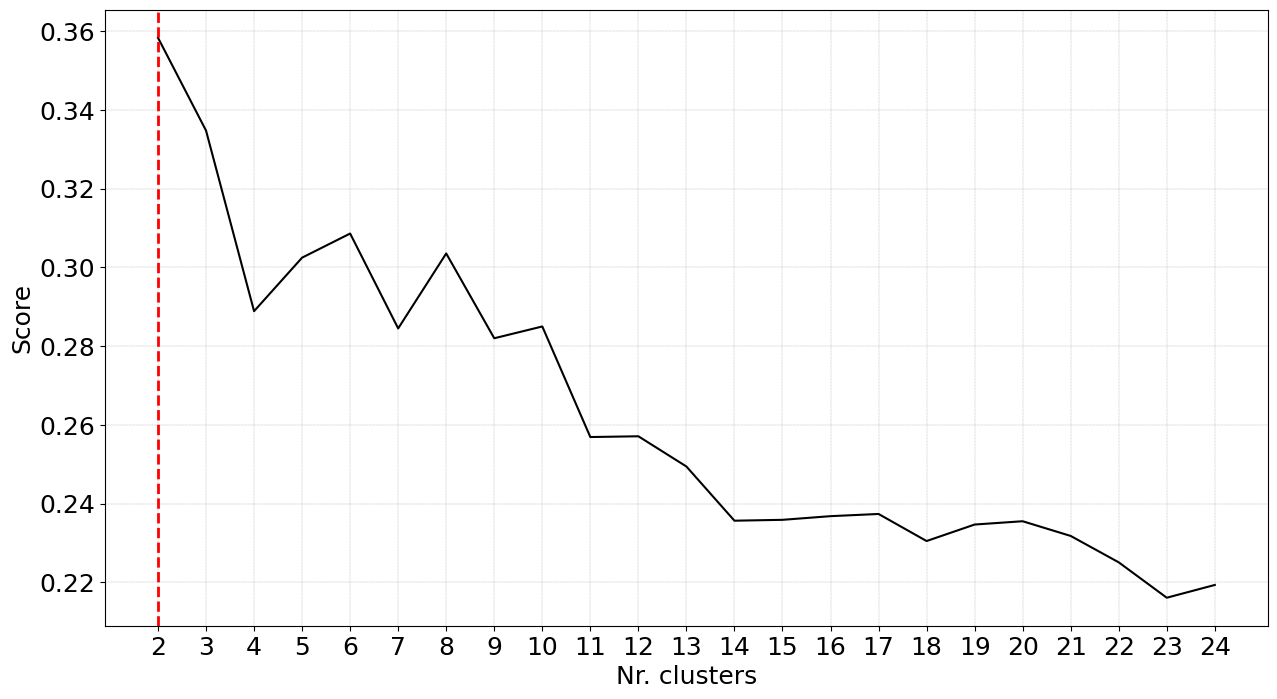

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 2, average silhouette_score=-0.007


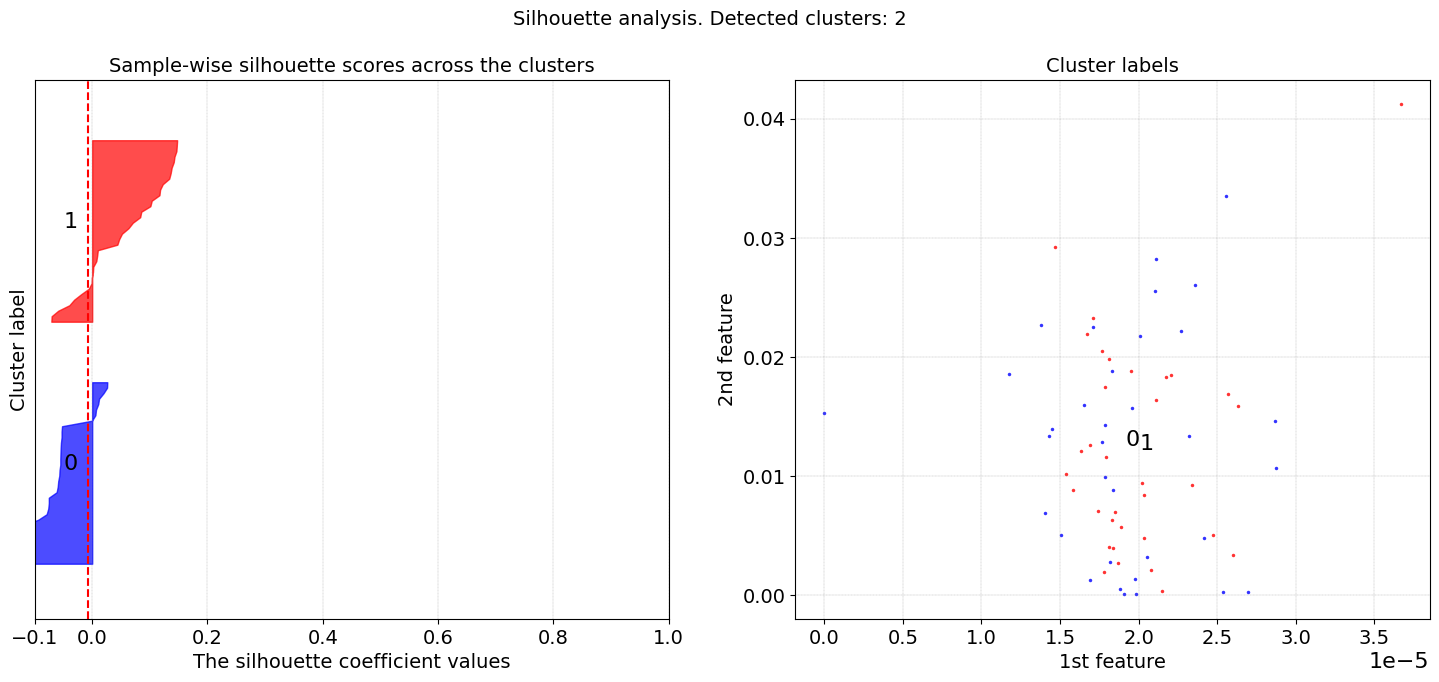

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=0.308. Be patient now..
[clusteval] >INFO> Compute cluster labels.


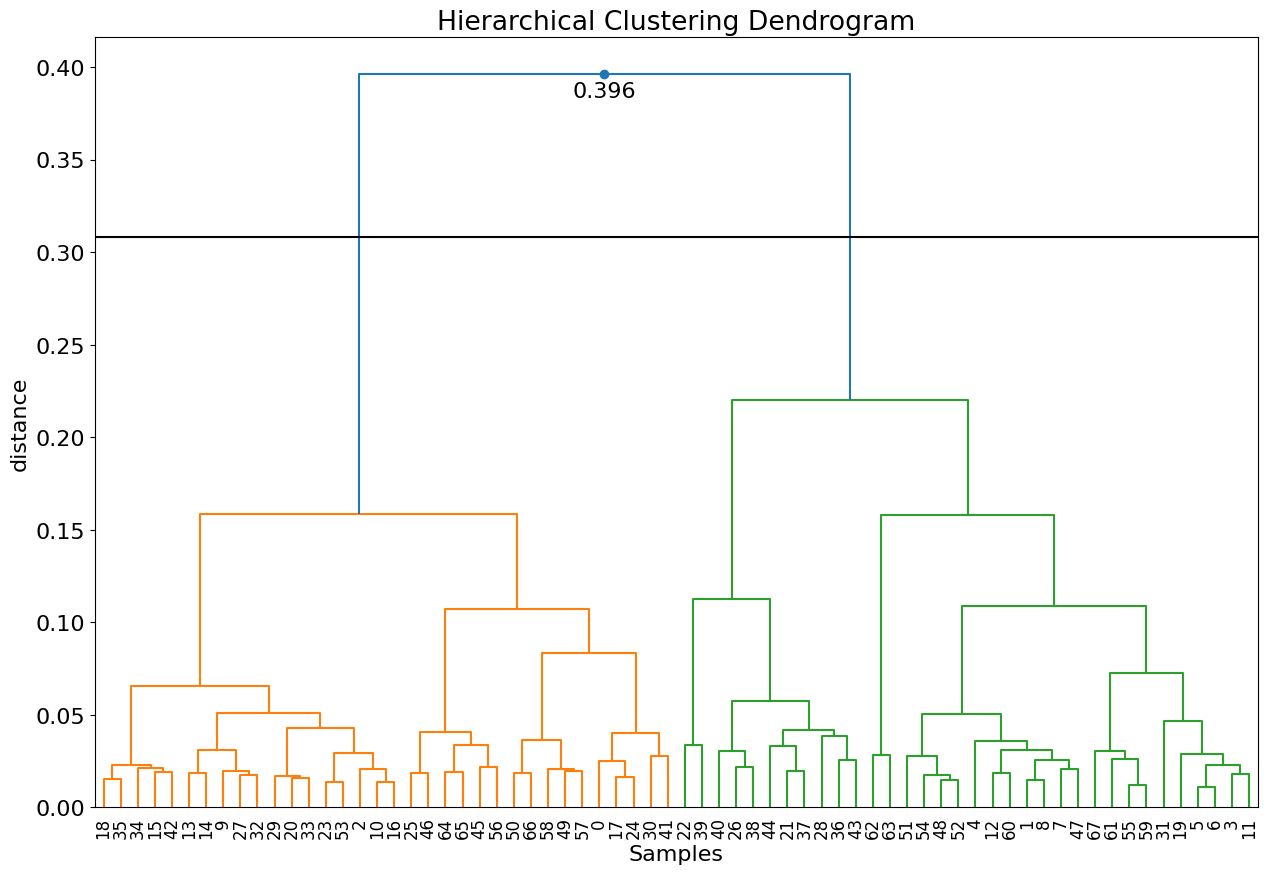

In [67]:
#data
df = pd.read_csv('../data/'+dir+'/data.csv')
df = df.loc[df['Group'] == 'MCI-AD']
patient_code = list(df['Code'])

drop_features = ['Code', 'CSF date', 'ug/uL','Volume for 40ug', 'Idade', 'Sexo','CSF data tTau', 'CSF data pTau', 'CSF data abeta42', 'Group']
#sdrop_features = ['code', 'Group']
df.drop(columns = drop_features, inplace = True)

#biclustering
biclustering = Biclustering()
X = biclustering.fit_transform(df)

# Initialize clustering
ce = clusteval(cluster='agglomerative', linkage='ward', evaluate='silhouette')

# Fit
results = ce.fit(X)
cluster_labels = results['labx']

# Plot
# Step 3: Reduce dimensionality for scatter plot (using PCA for 2D)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Step 4: Plot the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=50)

# Step 5: Annotate points with labels (here, we're using the original cluster labels)
for i in range(X_tsne.shape[0]):
    plt.annotate(patient_code[i], (X_tsne[i, 0], X_tsne[i, 1]), fontsize= 8, ha='center')

ce.plot()
ce.plot_silhouette(cmap = 'bwr')
ce.dendrogram()

dict = {'Code': patient_code, 'Cluster': cluster_labels} 
df_results = pd.DataFrame(dict)
df_results.to_csv(path + '/clusters.csv', index=False)